# Self-Driving Car Engineer Nanodegree

## Advanced Lane Line Finding Project !

This project is about finding lane lines on the road. It is called "Advanced Lane Line finding" because there is already a first version of a lane finder algorithm in https://github.com/Jeremy26/lane-lines

Today, we are using more sophisticated and fitted computer vision techniques to find lane lines on the road and evaluate the position of a car in a lane.

The steps will be the following : 
* Read images
* Process on Camera Calibration with a chessboard picture
* Correct image distortion
* Apply Color & Gradient Threshold in order to find the lanes
* Apply Perspective transform to have a bird's eye view of the road and not a perspective view
* Finally, we need to decide which pixels will be lane lines, we will work on curvatures, radius, and many more

## Read images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

## Process on Camera Calibration with a Chessboard Picture

### We first define object points and image points and draw chessboard Corners to check on Calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images using the Glob API
calibration_images = glob.glob('camera_cal/calibration*.jpg')
test_images = glob.glob('test_images/*.jpg')


An example of an object point (a corner) and its corresponding image point
[ 0.  0.  0.]
[[ 545.32281494  343.05032349]]


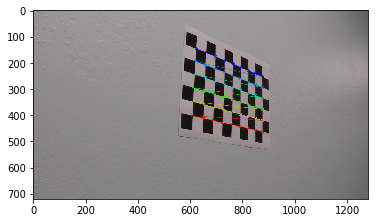

In [3]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(calibration_images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(image, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', image)
        plt.imshow(image)
        cv2.waitKey(500)
        
## An example of object points and image points
print("An example of an object point (a corner) and its corresponding image point")
print(objpoints[0][0])
print(imgpoints[0][0])
cv2.destroyAllWindows()

#### Then, we are ready to do the camera calibration and undistortion and display one example

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

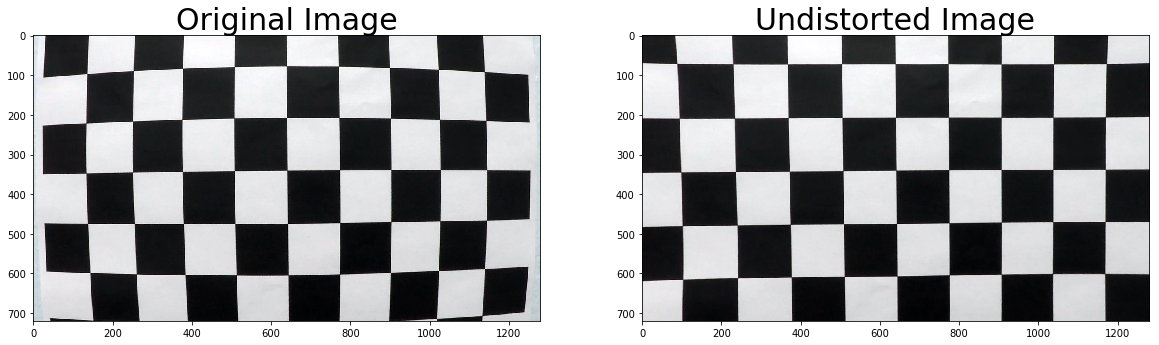

In [5]:
for idx, fname in enumerate (calibration_images):
    img = cv2.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # Test on one image
    if (idx==0):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=30)

## Apply Color & Gradient Threshold in order to find the lanes

In [16]:
def color_gradient(img, s_thresh, sx_thresh):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    hls =cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) 
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s2_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s2_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

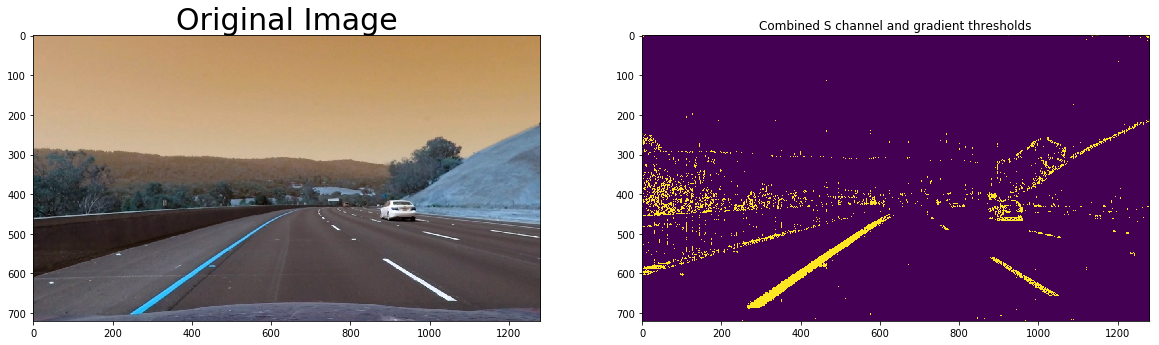

In [18]:
for idx, fname in enumerate (test_images):
    img = cv2.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    color_binary = color_gradient(img,(150, 255), (10, 120))

    # Test on one image
    if (idx==4):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(undistorted)
        ax1.set_title('Original Image', fontsize=30)
        #ax2.imshow(undistorted)
        #ax2.set_title('Undistorted Image', fontsize=30)
        ax2.imshow(color_binary)
        ax2.set_title('Combined S channel and gradient thresholds')

## Apply perspective Transform

In [37]:
def perspective_transform(img):
    ## The given image is already undistorted
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[600,400],[700,400],[1100,700],[200,700]])
    dst = np.float32([[400, 100], [900, 100],[900, 700],[400,700]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

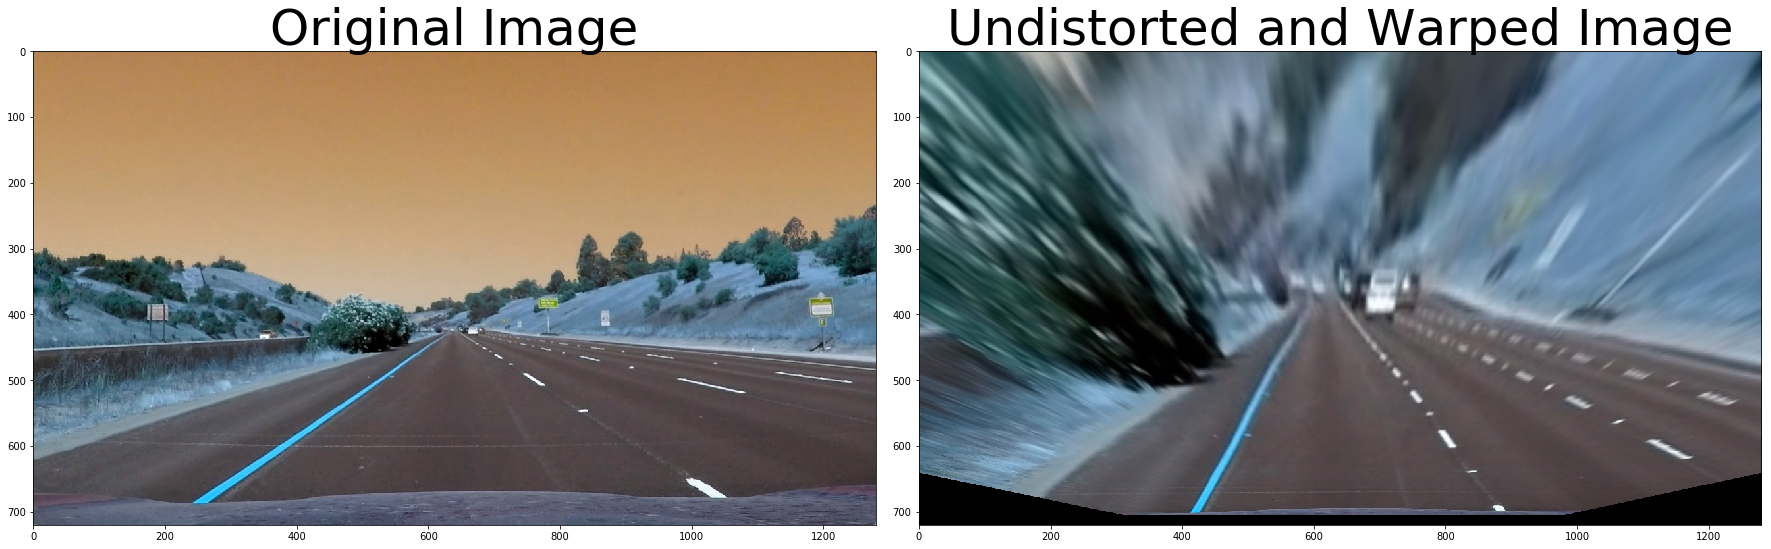

In [45]:
for idx, fname in enumerate (test_images):
    img = cv2.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    color_binary = color_gradient(img,(170, 255), (15, 100))
    top_down, perspective_M = perspective_transform(undistorted)
    
    if (idx==0):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(top_down)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## At this point, we need to identify the right lanes from the left lanes